## Overview of the project##
Placeholder for now.
I will also listed my references here.
In this project, I used reproducible functions (msv1 and msv2) from Ami to analyze and visulize missing data. 
https://www.kaggle.com/amiiiney/price-prediction-regularization-stacking

In [47]:
# Import core libraries (might import more while I make progress) Some of the libraries might not be used for now.
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read the train and test datasets

df_train = pd.read_csv('ames_train.csv')
df_test = pd.read_csv('ames_test.csv')

In [4]:
#display the first five rows of the train dataset.
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#check the data size
print("\nThe train data size is : {} ".format(df_train.shape)) 
print("The test data size is : {} ".format(df_test.shape))


The train data size is : (1460, 81) 
The test data size is : (1459, 80) 


In [6]:
#check all the predictors
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
# Check descriptive statistics summary on the target variable
df_train['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

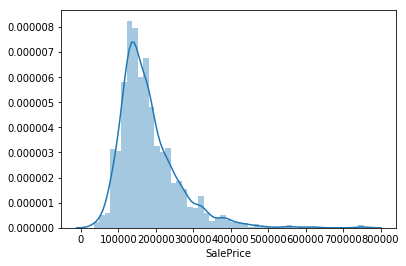

In [9]:
# Run histogram and check the distribution of the target variable
sns.distplot(df_train['SalePrice'])

Note: apparently, SalePrice is not in a normal distribution, so I'm considering doing a log transformation.
Also, I need to deal with the outliers (the expensive houses).

In [10]:
# Check skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


I did some research and made a few educated guesses. I will check the relationships between a few potentially important variables and the target variable.

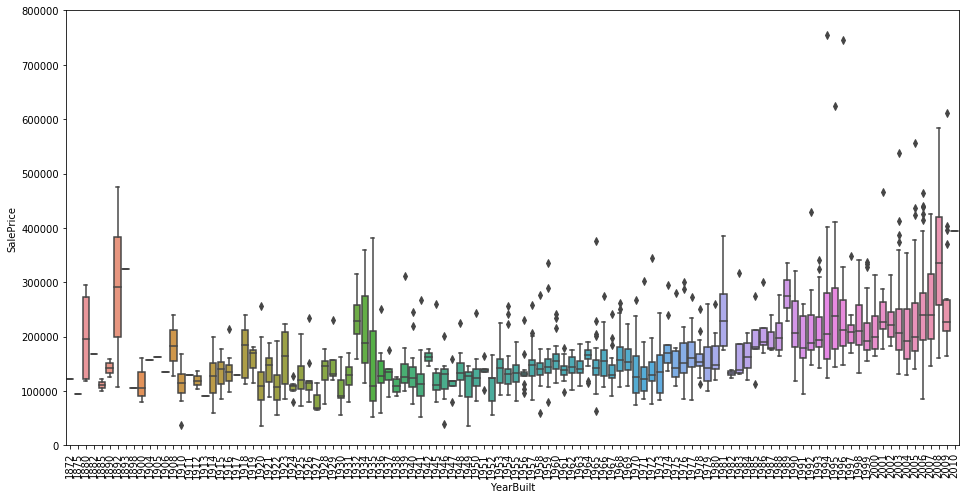

In [11]:
# Age of the house vs. SalePrice
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

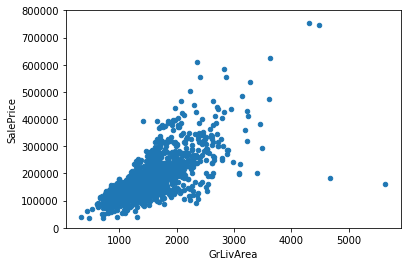

In [12]:
# size vs. saleprice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

I will stop testing other variables for now because I will run feature importance analysis to select potentially important predicting variables.

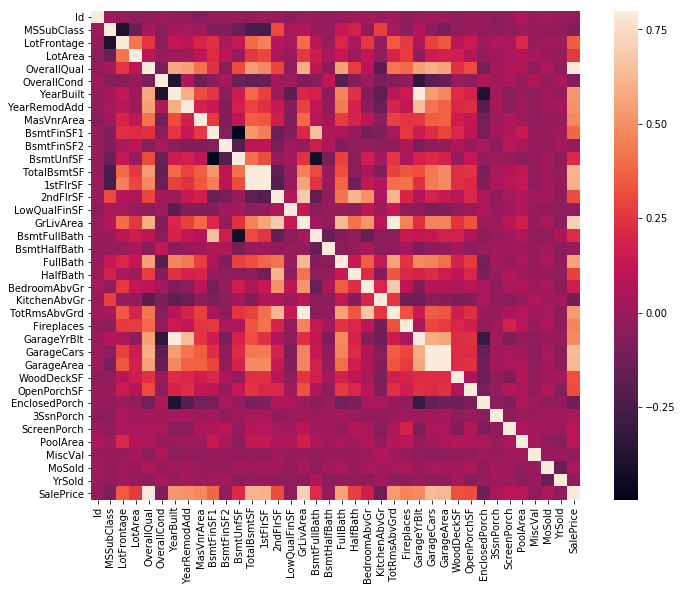

In [15]:
# run correlation matrix (I may change the color later)
corrmatrix = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, vmax=.8, square=True);

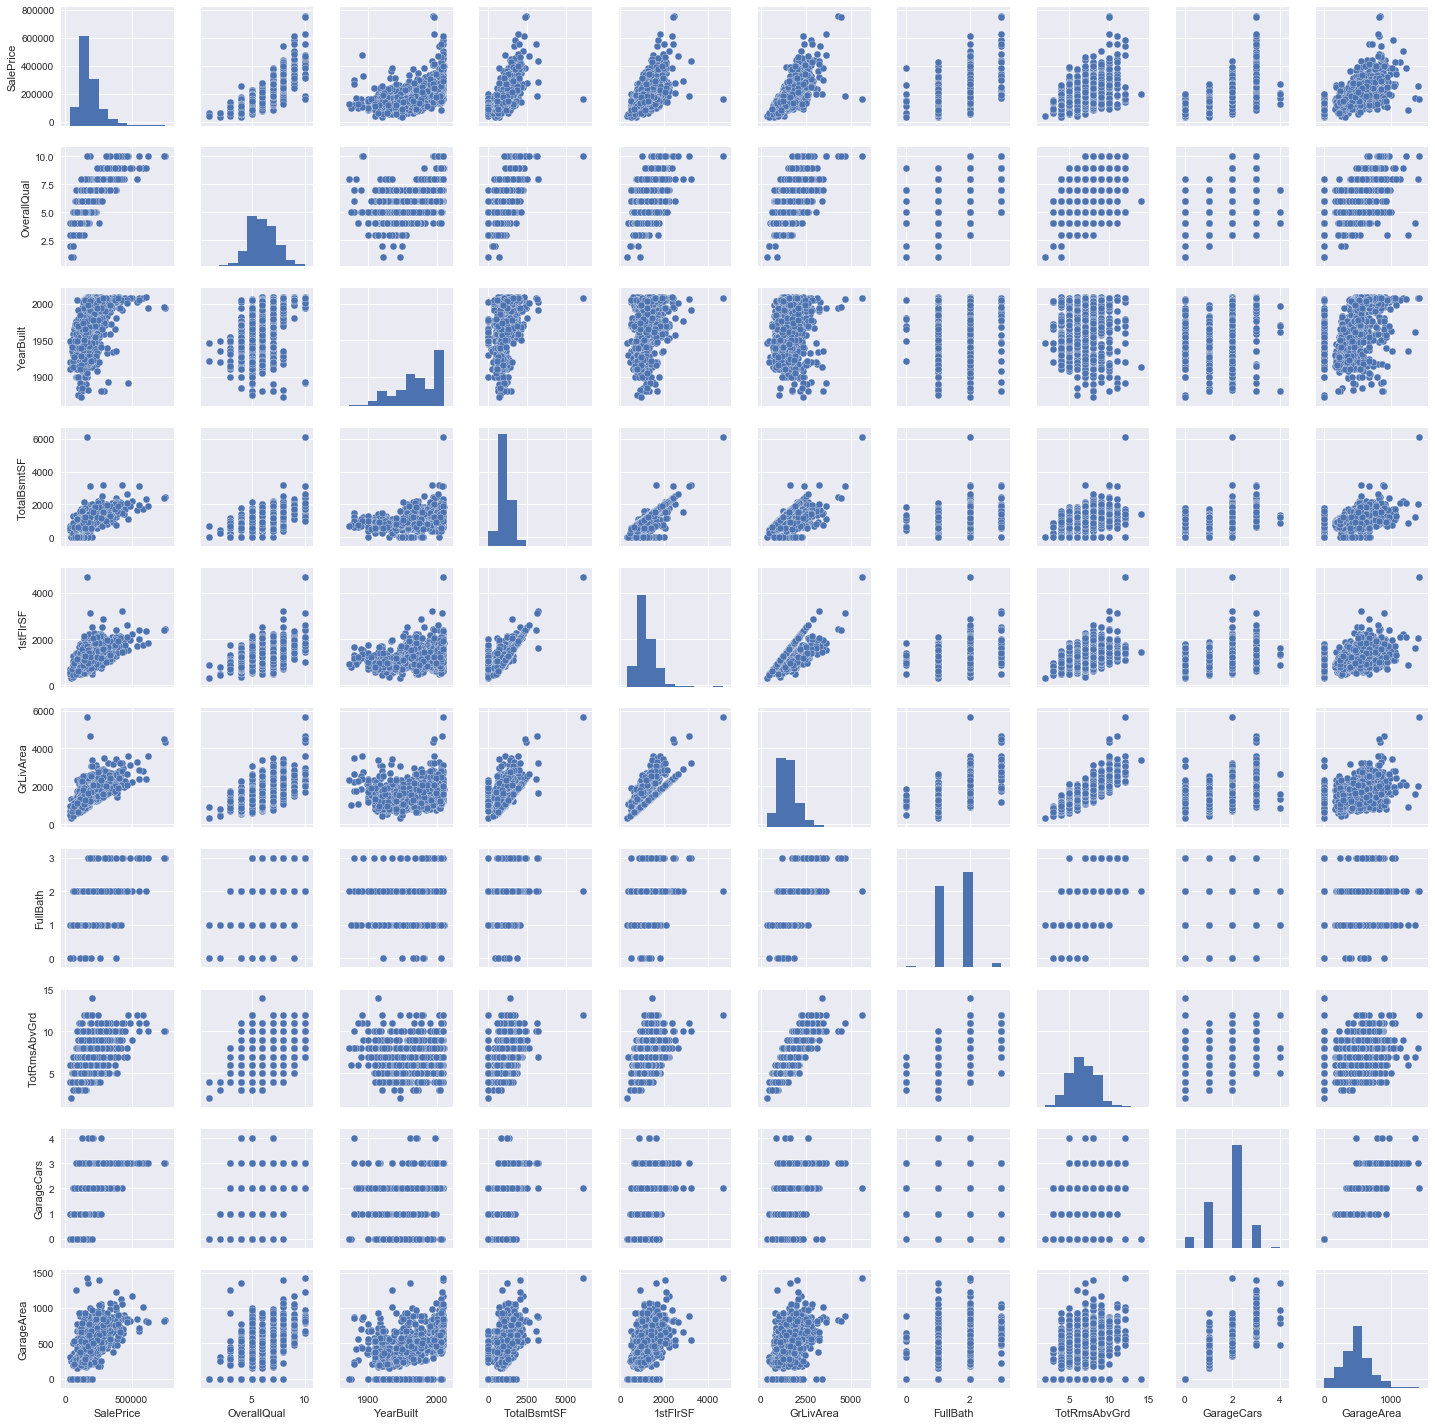

In [17]:
# Select a few potential important factors and run the scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']
sns.pairplot(df_train[cols], size = 2)
plt.show();

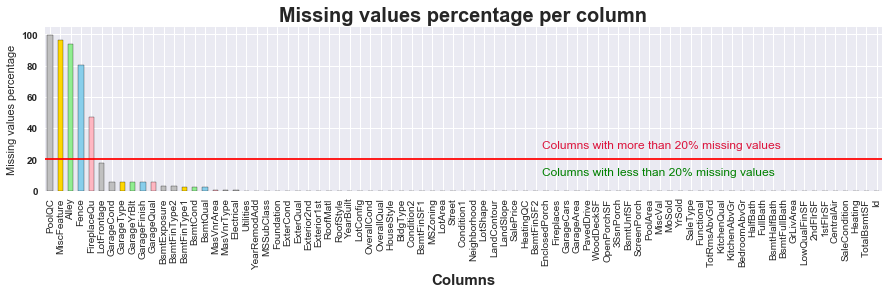

In [18]:
# analyzing missing data, the msv1 function is written by Ami
def msv1(data, thresh=20, color='black', edgecolor='black', width=15, height=3):
    """
    SOURCE: https://www.kaggle.com/amiiiney/price-prediction-regularization-stacking
    """
    
    plt.figure(figsize=(width,height))
    percentage=(data.isnull().mean())*100
    percentage.sort_values(ascending=False).plot.bar(color=color, edgecolor=edgecolor)
    plt.axhline(y=thresh, color='r', linestyle='-')
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, 'Columns with more than %s%s missing values' %(thresh, '%'), fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, 'Columns with less than %s%s missing values' %(thresh, '%'), fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()

msv1(df_train, 20, color=('silver', 'gold', 'lightgreen', 'skyblue', 'lightpink'))

In [26]:
# delete all the variables with more than 20% missing data
df_train1=df_train.dropna(thresh=len(df_train)*0.8, axis=1)
print(df_train.shape[1]- df_train1.shape[1], ' features were deleted in the training set')

5  features were deleted in the training set


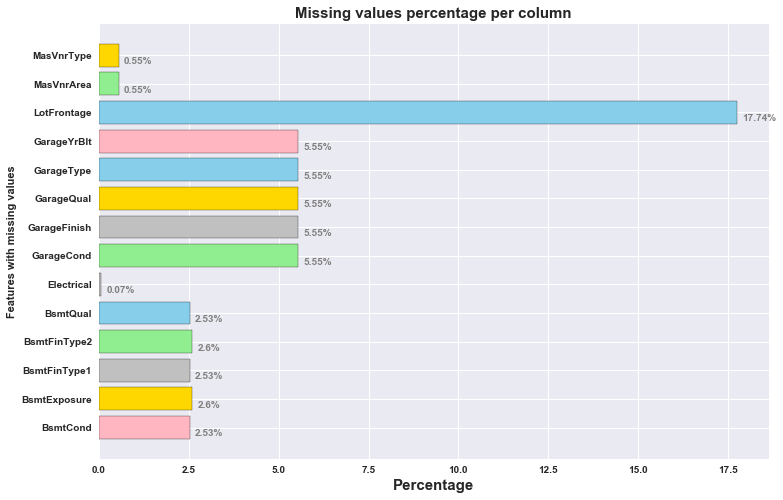

In [27]:
#Further check the variables with missing data. MSV function is written by Ami

allna = (df_train1.isnull().sum() / len(df_train1))*100
allna = allna.drop(allna[allna == 0].index).sort_values()

def msv2(data, width=12, height=8, color=('silver', 'gold','lightgreen','skyblue','lightpink'), edgecolor='black'):
    """
    SOURCE: https://www.kaggle.com/amiiiney/price-prediction-regularization-stacking
    """
    fig, ax = plt.subplots(figsize=(width, height))

    allna = (data.isnull().sum() / len(data))*100
    tightout= 0.008*max(allna)
    allna = allna.drop(allna[allna == 0].index).sort_values().reset_index()
    mn= ax.barh(allna.iloc[:,0], allna.iloc[:,1], color=color, edgecolor=edgecolor)
    ax.set_title('Missing values percentage per column', fontsize=15, weight='bold' )
    ax.set_xlabel('Percentage', weight='bold', size=15)
    ax.set_ylabel('Features with missing values', weight='bold')
    plt.yticks(weight='bold')
    plt.xticks(weight='bold')
    for i in ax.patches:
        ax.text(i.get_width()+ tightout, i.get_y()+0.1, str(round((i.get_width()), 2))+'%',
            fontsize=10, fontweight='bold', color='grey')
    return plt.show()

msv2(df_train1)

In [ ]:
# I will later deal with the missing data in the training dataset.

In [29]:
# Using one hot coding to recode categorical variables
df_train2=pd.get_dummies(df_train1)
print(df_train1.shape)
print(df_train2.shape)

(1460, 76)
(1460, 272)


In [ ]:
# I've idetified some outliers (e.g., super expensive sale price), although some of them might not be outliers.
# Anyway, I will deal with them later.

In [30]:
# For now, I will do a log transformation on the target variable: SalePrice
df_train2["SalePrice"] = np.log1p(df_train2["SalePrice"])

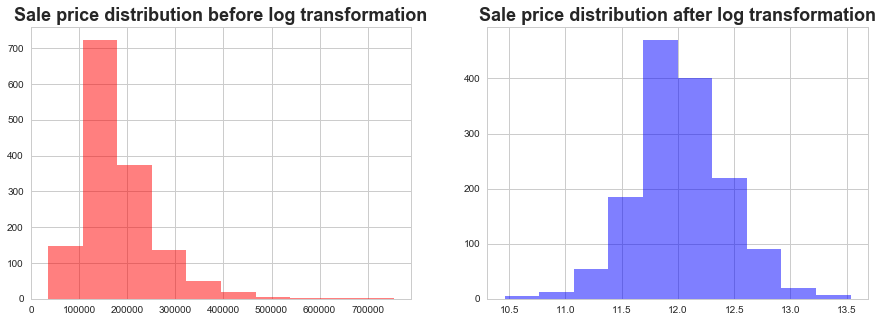

In [31]:
# Using seaborn to visulize the Sale Price before and after the log transformation
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
#1 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((1,2),(0,0))
plt.hist(df_train1.SalePrice, bins=10, color='red',alpha=0.5)
plt.title('Sale price distribution before log transformation',weight='bold', fontsize=18)
#first row sec col
ax1 = plt.subplot2grid((1,2),(0,1))
plt.hist(df_train2.SalePrice, bins=10, color='blue',alpha=0.5)
plt.title('Sale price distribution after log transformation',weight='bold', fontsize=18)
plt.show()

### Start to work on the ml part of the project. For now I just simply try a few simple algorithms such as regression. I will try more advanced one later.

In [48]:
# Following the ML project convention, I will use x and y to represent the feture set and the target set.

y = df_train2['SalePrice']
X = df_train2.drop(['SalePrice'], axis=1)

In [49]:
print(X.head())
print(y.head())

   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60       65.000     8450            7            5       2003   
1   2          20       80.000     9600            6            8       1976   
2   3          60       68.000    11250            7            5       2001   
3   4          70       60.000     9550            7            5       1915   
4   5          60       84.000    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1          ...            \
0          2003     196.000         706          ...             
1          1976       0.000         978          ...             
2          2002     162.000         486          ...             
3          1970       0.000         216          ...             
4          2000     350.000         655          ...             

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1  

In [50]:
# Split the df_train2 datasets into training and testing datasets. Please note this is not talking about the original train and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .3, random_state=0)

In [51]:
# Simply run random forest as a base model. I need to figure out the error reasons but will stop for now.
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [52]:
# I will keep working on this project.